In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.risk_factors import PortfolioMetrics
from src.var_modules import RiskCalculator
from src.stress_scenarios import StressTester

In [2]:
# Initialisation rapide
TICKERS = ['AAPL', 'JPM', 'XOM', 'TLT']
WEIGHTS = [0.4, 0.2, 0.2, 0.2]
returns = DataLoader(TICKERS, "2020-01-01", "2025-12-31").calculate_returns(DataLoader(TICKERS, "2020-01-01", "2025-12-31").get_data())
calc = RiskCalculator(PortfolioMetrics(returns, WEIGHTS))

# Création d'une liste pour stocker les résultats
summary_data = []

# 1. Méthodes Classiques
vp, cp = calc.parametric_var_cvar()
vh, ch = calc.historical_var_cvar()
summary_data.append(["Paramétrique (Normale)", vp, cp, "Théorique"])
summary_data.append(["Historique (Réelle)", vh, ch, "Basé sur le passé"])

# 2. Stress Tests
scenarios = StressTester.get_scenarios()
for name, factor in scenarios.items():
    v_mc, c_mc, _ = calc.monte_carlo_var_cvar(stress_factor=factor)
    summary_data.append([f"Monte Carlo ({name})", v_mc, c_mc, f"Volatilité x{factor}"])

# Création du DataFrame
df_results = pd.DataFrame(summary_data, columns=["Méthode / Scénario", "VaR 95%", "CVaR 95%", "Note"])

# Formatage en pourcentage pour l'affichage
df_display = df_results.copy()
df_display["VaR 95%"] = df_display["VaR 95%"].apply(lambda x: f"{x:.2%}")
df_display["CVaR 95%"] = df_display["CVaR 95%"].apply(lambda x: f"{x:.2%}")

display(df_display)

Chargement des données pour ['AAPL', 'JPM', 'XOM', 'TLT']...


[*********************100%***********************]  4 of 4 completed


,Méthode / Scénario,VaR 95%,CVaR 95%,Note
0,Paramétrique (Normale),1.99%,2.51%,Théorique
1,Historique (Réelle),1.73%,2.93%,Basé sur le passé
2,Monte Carlo (Normal),2.01%,2.55%,Volatilité x1.0
3,Monte Carlo (Crise_Moderee),2.48%,3.15%,Volatilité x1.25
4,Monte Carlo (Crise_Majeure),3.01%,3.79%,Volatilité x1.5
5,Monte Carlo (Black_Swan),4.11%,5.21%,Volatilité x2.0


Chargement des données pour ['AAPL', 'JPM', 'XOM', 'TLT']...


[*********************100%***********************]  4 of 4 completed


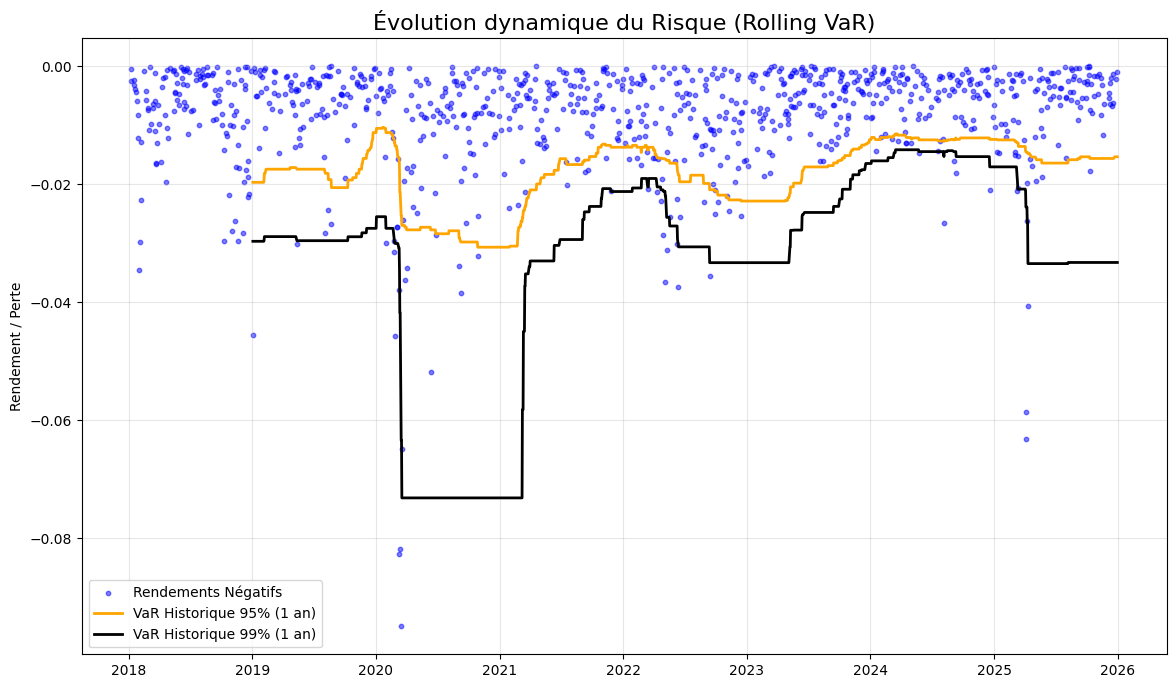

In [3]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

# Setup des imports
sys.path.append(os.path.abspath('..'))
from src.data_loader import DataLoader
from src.risk_factors import PortfolioMetrics

# 1. Préparation des données
TICKERS = ['AAPL', 'JPM', 'XOM', 'TLT']
WEIGHTS = [0.4, 0.2, 0.2, 0.2]

loader = DataLoader(TICKERS, "2018-01-01", "2025-12-31") # On prend une période plus large
data = loader.get_data()
returns = loader.calculate_returns(data)
metrics = PortfolioMetrics(returns, WEIGHTS)
portfolio_returns = metrics.get_weighted_returns() # Rendements du portefeuille global

# 2. Configuration de la VaR Roulante
window_days = 252  # Fenêtre de 1 an (historique glissant)
confidence_95 = 0.95
confidence_99 = 0.99

# Calcul magique avec Pandas (.rolling)
# On calcule le percentile sur les 252 jours précédents pour chaque jour
rolling_var_95 = portfolio_returns.rolling(window=window_days).quantile(1 - confidence_95)
rolling_var_99 = portfolio_returns.rolling(window=window_days).quantile(1 - confidence_99)

# 3. Création du Graphique (Style "Pro")
plt.figure(figsize=(14, 8))

# A. Les points bleus (Rendements quotidiens)
# On ne met que les rendements négatifs pour alléger le graph comme sur ton image
neg_returns = portfolio_returns[portfolio_returns < 0]
plt.scatter(neg_returns.index, neg_returns, color='blue', s=10, alpha=0.5, label='Rendements Négatifs')

# B. Les lignes de VaR (Le seuil de risque)
plt.plot(rolling_var_95.index, rolling_var_95, color='orange', linewidth=2, label='VaR Historique 95% (1 an)')
plt.plot(rolling_var_99.index, rolling_var_99, color='black', linewidth=2, label='VaR Historique 99% (1 an)')

# C. Mise en forme
plt.title("Évolution dynamique du Risque (Rolling VaR)", fontsize=16)
plt.ylabel("Rendement / Perte")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Optionnel : Colorier les zones de "Krach" (quand la perte dépasse la VaR 99)
# breaches = portfolio_returns[portfolio_returns < rolling_var_99]
# plt.scatter(breaches.index, breaches, color='red', s=30, zorder=5, label='Violations VaR 99%')

plt.show()